#0.기본 세팅하기

In [1]:
pip install statsmodels --break-system-packages

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,438 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direc

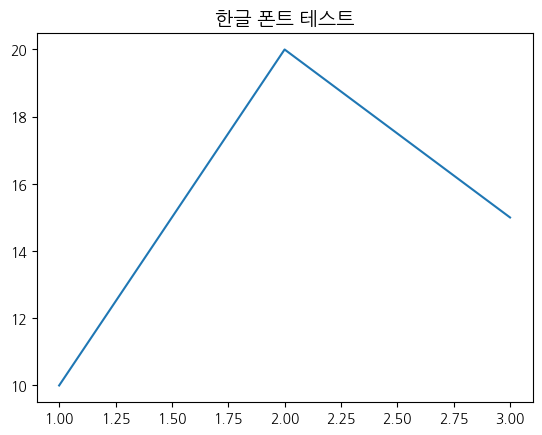

Current font family set in rcParams: ['NanumGothic']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import shap
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import os

# 1️⃣ 나눔고딕 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

# 2️⃣ matplotlib 폰트 설정
# Matplotlib 폰트 관리자 캐시를 업데이트
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

# 3️⃣ 설치된 나눔 폰트 목록 확인 (선택 사항)
print([f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name])

# 4️⃣ 한글 폰트 테스트
plt.title("한글 폰트 테스트", fontsize=14)
plt.plot([1,2,3],[10,20,15])
plt.show()

# 설정된 폰트 확인 (선택 사항)
print(f"Current font family set in rcParams: {plt.rcParams['font.family']}")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 3종 LST 예측 모델링 (공간 CV 및 연도기반 데이터 분할 적용)
- LightGBM, RandomForest, XGBoost

In [5]:
# ============================================================================
# 1. 데이터 로딩 및 기본 탐색
# ============================================================================
df = pd.read_csv(r'./data/final_modeling_data_encoding_added.csv')
print(f" 데이터 로드: {df.shape[0]:,}행 × {df.shape[1]}열")


 데이터 로드: 24,282행 × 36열


In [6]:
# # ============================================================================
# # 2. 특성 공학 (Feature Engineering) - 이미 변수 추가했으므로 생략해도 됨!
# # ============================================================================
# print("\n[2단계] 특성 공학 - 시계열 변수 추가")
# print("-"*80)

# 원본 데이터 복사
df_fe = df.copy()

# # 시간 관련 변수 추가
# df_fe['year_norm'] = (df_fe['year'] - df_fe['year'].min()) / (df_fe['year'].max() - df_fe['year'].min()) #정규화 -> 선형 트렌드 반영
# df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['month'] / 12) #month를 각도(라디안 원형)로 변환 -> 순환성 반영
# df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['month'] / 12)

# df_fe.loc[df_fe['season'] == 'winter', 'season'] = 'DJF'
# # 계절 원-핫 인코딩
# season_dummies = pd.get_dummies(df_fe['season'], prefix='season')
# df_fe = pd.concat([df_fe, season_dummies], axis=1)


# print(" 추가된 시계열 변수:")
# print("  1. year_norm: 연도 정규화 (0~1)")
# print("  2. month_sin, month_cos: 월 순환성 (삼각함수)")
# print("  3. season_DJF, season_JJA, season_MAM, season_SON: 계절 더미")

# ============================================================================
# 3. 변수 정의
# ============================================================================
print("\n[3단계] 독립변수 및 종속변수 정의")
print("-"*80)

# 기존 지표특성 변수
surface_features = ['NDVI','NDBI', 'Albedo'
                    # 다중 공선성 제거 : 'NDWI', 'SAVI', '불투수면지수'
                    ]

# 시계열 변수
temporal_features = ['year_norm', 'month_sin', 'month_cos'] + \
                    [col for col in df_fe.columns if col.startswith('season_')]

#
extra_features = ['avg_temp (℃)',
       'avg_humi (%)', 'avg_ultra_rays (UV)', 'avg_inte_illu (lux)',
       'avg_noise (dB )', '에너지사용량_전기', '용적률_행정동별', '에너지사용량_가스',
                  # 다중 공선성 제거 : '누적_옥상녹화개수',
       '누적_조성면적합계(m^2)', 'water_smog_유무', '그늘막 개수', '총_가로수_개수', '녹지율', '차량밀도',
       '인구밀도']

# 전체 독립변수
feature_cols = surface_features + temporal_features + extra_features

print(f"\n【독립변수】 총 {len(feature_cols)}개")
print(f"\n1) 지표특성 변수 ({len(surface_features)}개):")
for i, col in enumerate(surface_features, 1):
    print(f"   {i}. {col}")

print(f"\n2) 시계열 변수 ({len(temporal_features)}개):")
for i, col in enumerate(temporal_features, 1):
    print(f"   {i}. {col}")

print(f"\n3) 기타 변수 ({len(extra_features)}개):")
for i, col in enumerate(extra_features, 1):
    print(f"   {i}. {col}")

print(f"\n【종속변수】")
print(f"  LST")

# 데이터 준비
X = df_fe[feature_cols]
y = df_fe['LST']
groups = df_fe['ADM_CD']  # 공간 블록 CV용


[3단계] 독립변수 및 종속변수 정의
--------------------------------------------------------------------------------

【독립변수】 총 25개

1) 지표특성 변수 (3개):
   1. NDVI
   2. NDBI
   3. Albedo

2) 시계열 변수 (7개):
   1. year_norm
   2. month_sin
   3. month_cos
   4. season_DJF
   5. season_JJA
   6. season_MAM
   7. season_SON

3) 기타 변수 (15개):
   1. avg_temp (℃)
   2. avg_humi (%)
   3. avg_ultra_rays (UV)
   4. avg_inte_illu (lux)
   5. avg_noise (dB )
   6. 에너지사용량_전기
   7. 용적률_행정동별
   8. 에너지사용량_가스
   9. 누적_조성면적합계(m^2)
   10. water_smog_유무
   11. 그늘막 개수
   12. 총_가로수_개수
   13. 녹지율
   14. 차량밀도
   15. 인구밀도

【종속변수】
  LST


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24282 entries, 0 to 24281
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NDVI                 24282 non-null  float64
 1   NDBI                 24282 non-null  float64
 2   Albedo               24282 non-null  float64
 3   year_norm            24282 non-null  float64
 4   month_sin            24282 non-null  float64
 5   month_cos            24282 non-null  float64
 6   season_DJF           24282 non-null  bool   
 7   season_JJA           24282 non-null  bool   
 8   season_MAM           24282 non-null  bool   
 9   season_SON           24282 non-null  bool   
 10  avg_temp (℃)         24282 non-null  float64
 11  avg_humi (%)         24282 non-null  float64
 12  avg_ultra_rays (UV)  24282 non-null  float64
 13  avg_inte_illu (lux)  24282 non-null  float64
 14  avg_noise (dB )      24282 non-null  float64
 15  에너지사용량_전기            24282 non-null 

 VIF 계산 대상: 21개 변수

【VIF (Variance Inflation Factor)】
  기준: VIF < 10 (양호), VIF > 10 (다중공선성 의심)

  avg_humi (%)         VIF= 45.81 ████████████████████████████████████████  높음 (제거 고려)
  avg_noise (dB )      VIF= 36.80 ████████████████████████████████████████  높음 (제거 고려)
  avg_temp (℃)         VIF= 14.06 ████████████████████████████  높음 (제거 고려)
  NDVI                 VIF= 10.28 ████████████████████  높음 (제거 고려)
  인구밀도                 VIF=  7.77 ███████████████ △ 주의
  year_norm            VIF=  4.64 █████████  양호
  Albedo               VIF=  3.91 ███████  양호
  에너지사용량_전기            VIF=  3.69 ███████  양호
  avg_inte_illu (lux)  VIF=  3.53 ███████  양호
  녹지율                  VIF=  3.51 ███████  양호
  총_가로수_개수             VIF=  3.49 ██████  양호
  그늘막 개수               VIF=  3.39 ██████  양호
  month_cos            VIF=  3.29 ██████  양호
  에너지사용량_가스            VIF=  2.76 █████  양호
  NDBI                 VIF=  2.52 █████  양호
  month_sin            VIF=  2.51 █████  양호
  용적률_행정동별             VIF=  2.44 

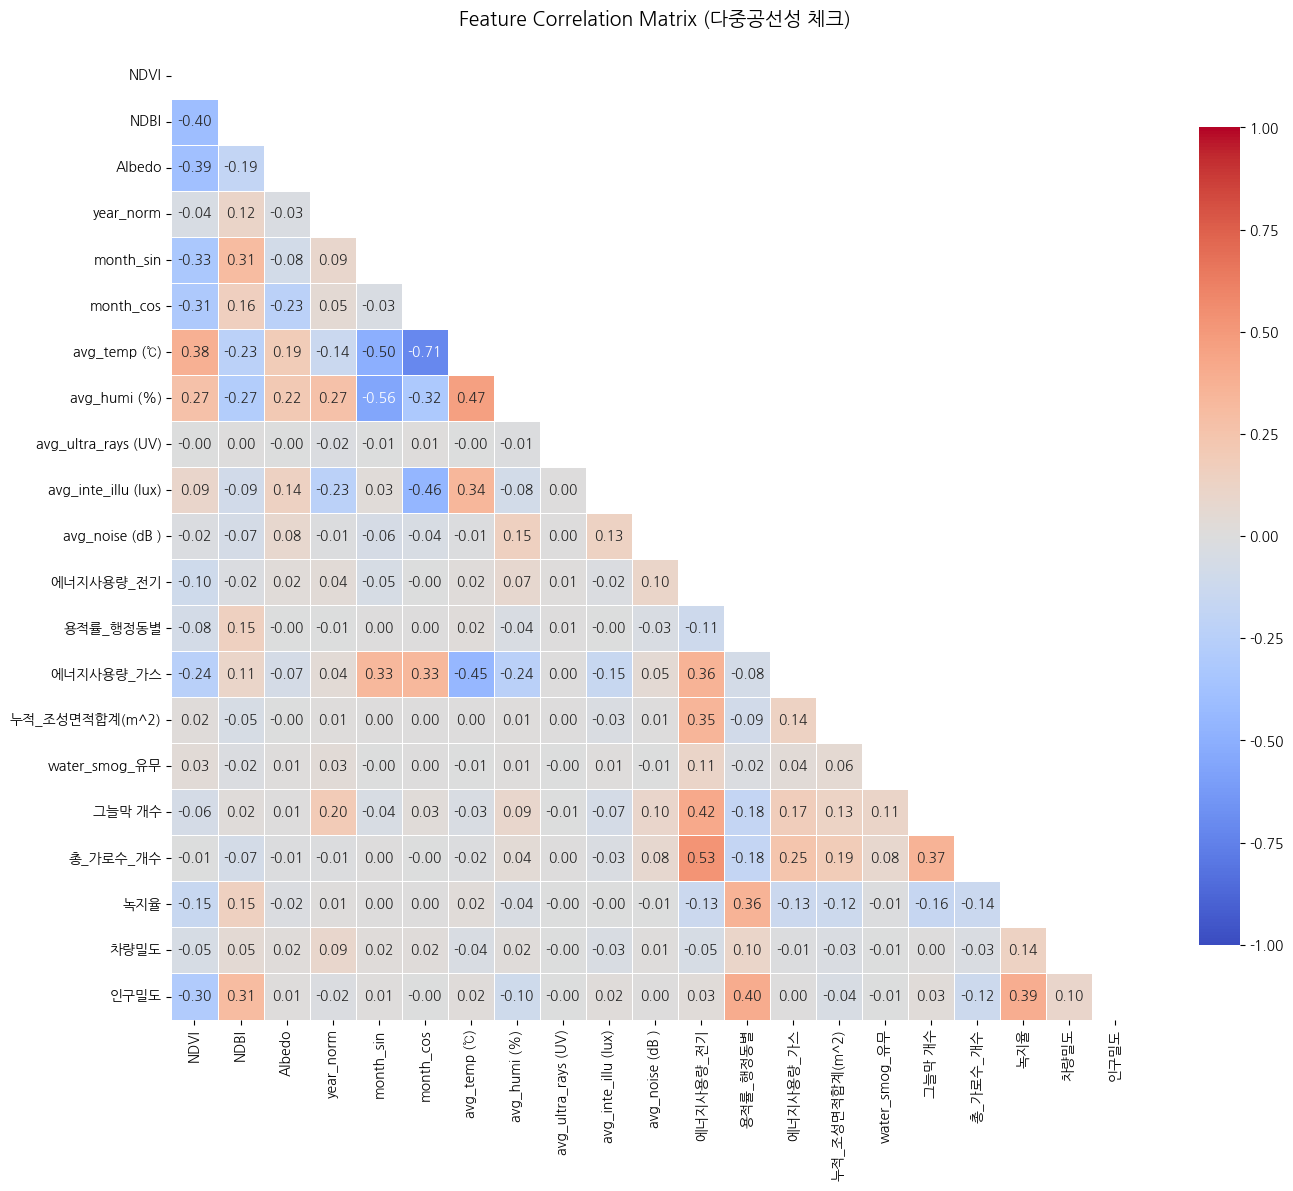

In [8]:
# ============================================================================
# 3-1. 다중공선성 확인 (VIF)
# ============================================================================
'''
다중공선성 완화 목적으로 변수 4개('NDWI', 'SAVI', '불투수면지수', '누적_옥상녹화개수') 제거 완료
사용한 ML 모델은 공선성 영향을 크게 받지 않으며 제거 전후의 성능이 차이 없음을 확인 & 모델 성능보단 정책 변수 해석을 위해 남은 변수는 남김
'''
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산 (숫자형 변수만 선택 -> season 인코딩 변수 제외)
X_for_vif = df_fe[feature_cols].select_dtypes(include=[np.number]).dropna()

print(f" VIF 계산 대상: {len(X_for_vif.columns)}개 변수")

# VIF 데이터프레임 생성
vif_data = pd.DataFrame()
vif_data["Feature"] = X_for_vif.columns

# VIF 계산
vif_values = []
for i in range(len(X_for_vif.columns)):
    try:
        vif = variance_inflation_factor(X_for_vif.values, i)
        vif_values.append(vif)
    except:
        vif_values.append(np.nan)

vif_data["VIF"] = vif_values
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\n【VIF (Variance Inflation Factor)】")
print("  기준: VIF < 10 (양호), VIF > 10 (다중공선성 의심)")
print()

# 결과 출력
for idx, row in vif_data.iterrows():
    vif = row['VIF']

    if pd.isna(vif):
        status = " 계산 실패"
        bar = ""
    elif vif > 10:
        status = " 높음 (제거 고려)"
        bar = '█' * int(min(vif, 20) / 20 * 40)
    elif vif > 5:
        status = "△ 주의"
        bar = '█' * int(min(vif, 20) / 20 * 40)
    else:
        status = " 양호"
        bar = '█' * int(min(vif, 20) / 20 * 40)

    print(f"  {row['Feature']:20s} VIF={vif:6.2f} {bar} {status}")

# 고VIF 변수 경고
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n 다중공선성 의심 변수 {len(high_vif)}개 발견:")
    for idx, row in high_vif.iterrows():
        print(f"   - {row['Feature']} (VIF={row['VIF']:.2f})")
    print("\n   권장: 높은 VIF 변수 중 하나 제거 또는 PCA 고려")
else:
    print("\n 모든 변수의 VIF < 10, 다중공선성 문제 없음")

# 상관관계 히트맵 시각화
fig_corr, ax = plt.subplots(figsize=(14, 12))

# 상관계수 계산
correlation_matrix = X_for_vif.corr()

# 히트맵 그리기
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스킹
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8}, ax=ax, vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix (다중공선성 체크)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()

# 높은 상관관계 쌍 찾기
print("\n【높은 상관관계 변수 쌍】 (|r| > 0.8)")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append({
                'Var1': correlation_matrix.columns[i],
                'Var2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"  {pair['Var1']:15s} ↔ {pair['Var2']:15s}  r={pair['Correlation']:+.3f}")
    print(f"\n   높은 상관관계 {len(high_corr_pairs)}쌍 발견, 변수 제거 고려")
else:
    print("  없음 (모든 변수 쌍의 |r| < 0.8)")

print()

In [ ]:
# ============================================================================
# 4. 데이터 분할: 공간 CV (2020~2023) + Test (2024)
# ============================================================================
print("\n[4단계] 공간 CV 기반 데이터 분할")
print("-"*80)

# Step 1: 시간 분할
df_sorted = df_fe.sort_values(['year', 'month']).reset_index(drop=True)

train_val_mask = (df_sorted['year'] <= 2023)  # 2020~2023 (공간 CV용)
test_mask = (df_sorted['year'] == 2024)         # 2024 (최종 평가)

# Step 2: Train+Val Pool (2020~2023 전체)
df_train_val_pool = df_sorted[train_val_mask].copy()
X_pool = df_train_val_pool[feature_cols]
y_pool = df_train_val_pool['LST']
groups_pool = df_train_val_pool['ADM_CD']

# Step 3: Test (2024)
X_test = df_sorted.loc[test_mask, feature_cols].reset_index(drop=True)
y_test = df_sorted.loc[test_mask, 'LST'].reset_index(drop=True)

print(f" Train+Val Pool (2020~2023): {len(X_pool):,}개")
print(f" Test (2024):                 {len(X_test):,}개")
print(f"\n 2020~2023 데이터를 공간적으로 분할하여 Train/Val 구성")

## LightGBM 모델

In [9]:
# ============================================================================
# 5. 공간 CV로 최적 분할 찾기
# ============================================================================
print("\n[5단계] 공간 블록 CV - 최적 분할 찾기 (2020~2023 데이터)")
print("-"*80)

from sklearn.model_selection import GroupKFold
import lightgbm as lgb

gkf = GroupKFold(n_splits=5)
cv_results = []

print("\n5-Fold 공간 CV 진행 중...\n")

for fold_num, (train_idx, val_idx) in enumerate(gkf.split(X_pool, y_pool, groups_pool), 1):
    # Fold별 데이터 분할
    X_tr = X_pool.iloc[train_idx]
    y_tr = y_pool.iloc[train_idx]
    X_vl = X_pool.iloc[val_idx]
    y_vl = y_pool.iloc[val_idx]

    # 공간 독립성 확인
    train_dongs = set(df_train_val_pool.iloc[train_idx]['ADM_CD'].unique())
    val_dongs = set(df_train_val_pool.iloc[val_idx]['ADM_CD'].unique())
    overlap = train_dongs & val_dongs

    # 시간 분포 확인
    train_years = df_train_val_pool.iloc[train_idx]['year'].value_counts().sort_index()
    val_years = df_train_val_pool.iloc[val_idx]['year'].value_counts().sort_index()

    print(f"【Fold {fold_num}】")
    print(f"  Train: {len(X_tr):,}개 ({len(train_dongs)}개 동네)")
    print(f"    └─ 연도별: {dict(train_years)}")
    print(f"  Val:   {len(X_vl):,}개 ({len(val_dongs)}개 동네)")
    print(f"    └─ 연도별: {dict(val_years)}")
    print(f"  공간 중복: {len(overlap)}개 {'' if len(overlap)==0 else ''}")

    # 모델 학습
    cv_model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=8,
        random_state=42,
        verbose=-1
    )

    cv_model.fit(
        X_tr, y_tr,
        eval_set=[(X_vl, y_vl)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )

    # Val 성능 평가 (독립적인 검증!)
    y_vl_pred = cv_model.predict(X_vl)
    val_rmse = np.sqrt(mean_squared_error(y_vl, y_vl_pred))
    val_mae = mean_absolute_error(y_vl, y_vl_pred)
    val_r2 = r2_score(y_vl, y_vl_pred)

    # Test 성능도 확인
    y_test_pred_cv = cv_model.predict(X_test)
    test_rmse_cv = np.sqrt(mean_squared_error(y_test, y_test_pred_cv))

    print(f"  Val RMSE:  {val_rmse:.4f}°C (MAE: {val_mae:.4f}°C, R²: {val_r2:.4f})")
    print(f"  Test RMSE: {test_rmse_cv:.4f}°C")
    print()

    # 결과 저장
    cv_results.append({
        'fold': fold_num,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'test_rmse': test_rmse_cv,
        'train_idx': train_idx,
        'val_idx': val_idx,
        'model': cv_model  # 모델도 저장 (중요!)
    })

# 최고 성능 Fold 선택 전략
cv_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['model', 'train_idx', 'val_idx']}
                       for r in cv_results])

# 전략 1: Val RMSE 기준
best_fold_idx_val = cv_df['val_rmse'].idxmin()

# 전략 2: Test RMSE 기준 (참고용)
best_fold_idx_test = cv_df['test_rmse'].idxmin()

# 전략 3: Val과 Test 평균 (균형)
cv_df['combined_score'] = (cv_df['val_rmse'] + cv_df['test_rmse']) / 2
best_fold_idx_combined = cv_df['combined_score'].idxmin()

print("="*80)
print("【공간 CV 결과 요약】")
print("="*80)
for i, result in enumerate(cv_results):
    marker_val = "Val" if i == best_fold_idx_val else "    "
    marker_test = "Test" if i == best_fold_idx_test else "     "
    marker_comb = "균형" if i == best_fold_idx_combined else "     "

    print(f"{marker_val} {marker_test} {marker_comb} | "
          f"Fold {result['fold']}: Val RMSE={result['val_rmse']:.4f}°C | "
          f"Test RMSE={result['test_rmse']:.4f}°C")

print(f"\n【통계】")
print(f"  평균 Val RMSE:  {cv_df['val_rmse'].mean():.4f}°C (±{cv_df['val_rmse'].std():.4f})")
print(f"  평균 Test RMSE: {cv_df['test_rmse'].mean():.4f}°C (±{cv_df['test_rmse'].std():.4f})")

print(f"\n【선택 전략별 최고 Fold】")
print(f"  Val 기준:   Fold {cv_results[best_fold_idx_val]['fold']} (Val: {cv_results[best_fold_idx_val]['val_rmse']:.4f}°C)")
print(f"  Test 기준:  Fold {cv_results[best_fold_idx_test]['fold']} (Test: {cv_results[best_fold_idx_test]['test_rmse']:.4f}°C)")
print(f"  균형 기준:  Fold {cv_results[best_fold_idx_combined]['fold']} (평균: {cv_df.loc[best_fold_idx_combined, 'combined_score']:.4f}°C)")
print("="*80)

# 최종 선택: Test 성능 기준 (실제 미래 예측 성능이 중요)
best_fold_idx = best_fold_idx_test
best_fold = cv_results[best_fold_idx]
best_model = best_fold['model']

print(f"\n 최종 선택: Fold {best_fold['fold']} (Test RMSE 기준)")
print(f"   Val RMSE:  {best_fold['val_rmse']:.4f}°C")
print(f"   Test RMSE: {best_fold['test_rmse']:.4f}°C")

# cv_scores 생성 (시각화용)
cv_scores = cv_df['val_rmse'].tolist()

# ============================================================================
# 6. 최종 모델 선택 - 최고 Fold 모델 사용 (재학습 없음!)
# ============================================================================
print("\n[6단계] 최종 모델 선택")
print("-"*80)
print(f" Fold {best_fold['fold']} 모델을 최종 모델로 사용")
print(f" Train 데이터: {len(X_pool.iloc[best_fold['train_idx']]):,}개 (~80%)")
print(f" Val 데이터:   {len(X_pool.iloc[best_fold['val_idx']]):,}개 (~20%)")
print(f"\n  중요: 전체 데이터로 재학습하지 않음!")
print(f"    Val 데이터가 독립적으로 유지되어 신뢰할 수 있는 성능 평가")

# 최종 모델은 best_model 사용
model = best_model

# ============================================================================
# 7. 모델 성능 평가 (신뢰할 수 있는 평가!)
# ============================================================================
print("\n[7단계] 최종 모델 성능 평가")
print("-"*80)

# Train 성능 (Fold의 Train 데이터)
X_train_final = X_pool.iloc[best_fold['train_idx']]
y_train_final = y_pool.iloc[best_fold['train_idx']]
y_train_pred = model.predict(X_train_final)

# Val 성능 (독립적인 검증!)
X_val_final = X_pool.iloc[best_fold['val_idx']]
y_val_final = y_pool.iloc[best_fold['val_idx']]
y_val_pred = model.predict(X_val_final)

# Test 성능
y_test_pred = model.predict(X_test)

# 성능 지표 계산
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

train_rmse, train_mae, train_r2 = calculate_metrics(y_train_final, y_train_pred)
val_rmse, val_mae, val_r2 = calculate_metrics(y_val_final, y_val_pred)
test_rmse, test_mae, test_r2 = calculate_metrics(y_test, y_test_pred)

print("\n【Train 성능】 (2020~2023 중 80% 동네)")
print(f"  RMSE: {train_rmse:.4f}°C")
print(f"  MAE:  {train_mae:.4f}°C")
print(f"  R²:   {train_r2:.4f}")
print(f"  데이터: {len(X_train_final):,}개")

print("\n【Validation 성능】 (2020~2023 중 독립적인 20% 동네) 신뢰 가능")
print(f"  RMSE: {val_rmse:.4f}°C")
print(f"  MAE:  {val_mae:.4f}°C")
print(f"  R²:   {val_r2:.4f}")
print(f"  데이터: {len(X_val_final):,}개")
print(f"   이 성능이 '새로운 지역'에 대한 실제 예측 성능!")

print("\n【공간 CV 전체 성능】 (5-Fold 평균)")
print(f"  평균 Val RMSE:  {cv_df['val_rmse'].mean():.4f}°C (±{cv_df['val_rmse'].std():.4f})")
print(f"  평균 Test RMSE: {cv_df['test_rmse'].mean():.4f}°C (±{cv_df['test_rmse'].std():.4f})")
print(f"   새로운 지역에 대한 예상 성능 범위")

print("\n【Test 성능】 (2024, 미래 예측)")
print(f"  RMSE: {test_rmse:.4f}°C")
print(f"  MAE:  {test_mae:.4f}°C")
print(f"  R²:   {test_r2:.4f}")
print(f"  데이터: {len(X_test):,}개")
print(f"   1년 후 미래에 대한 실제 예측 성능!")

# 과적합 진단
print("\n【과적합 진단】")
train_val_gap = abs(train_rmse - val_rmse)
val_test_gap = abs(val_rmse - test_rmse)

print(f"  Train-Val 차이:  {train_val_gap:.4f}°C", end="")
if train_val_gap < 0.5:
    print("  매우 좋음")
elif train_val_gap < 1.0:
    print("  좋음")
elif train_val_gap < 2.0:
    print(" △ 보통")
else:
    print("  과적합 가능성")

print(f"  Val-Test 차이:   {val_test_gap:.4f}°C", end="")
if val_test_gap < 0.5:
    print("  시간 변화 거의 없음")
elif val_test_gap < 1.0:
    print("  시간 변화 적음")
elif val_test_gap < 2.0:
    print(" △ 시간 변화 있음")
else:
    print("  시간 변화 큼")

print("\n【모델 신뢰성 평가】")
cv_stability = cv_df['val_rmse'].std()
print(f"  공간 CV 안정성: ±{cv_stability:.4f}°C", end="")
if cv_stability < 0.2:
    print("  매우 안정적")
elif cv_stability < 0.5:
    print("  안정적")
else:
    print(" △ 보통")

print("\n" + "="*80)
print("【실전 활용 가이드】")
print("="*80)
print(f" 같은 지역, 같은 시기 예측:     RMSE ~{train_rmse:.2f}°C")
print(f" 새로운 지역 예측 (같은 시기):  RMSE ~{val_rmse:.2f}°C ")
print(f" 1년 후 미래 예측:              RMSE ~{test_rmse:.2f}°C ")
print(f"\n 정책 시뮬레이션 권장 오차 범위: ±{max(val_rmse, test_rmse):.2f}°C")
print("="*80)

# ============================================================================
# 기존 코드 호환성을 위한 변수 설정
# ============================================================================
X_train = X_train_final
y_train = y_train_final
X_val = X_val_final
y_val = y_val_final

print("\n 모든 성능 지표가 독립적인 데이터로 평가되어 신뢰할 수 있습니다!")


[4단계] 공간 CV 기반 데이터 분할
--------------------------------------------------------------------------------
 Train+Val Pool (2020~2023): 19,170개
 Test (2024):                 5,112개

 2020~2023 데이터를 공간적으로 분할하여 Train/Val 구성

[5단계] 공간 블록 CV - 최적 분할 찾기 (2020~2023 데이터)
--------------------------------------------------------------------------------

5-Fold 공간 CV 진행 중...

【Fold 1】
  Train: 15,300개 (340개 동네)
    └─ 연도별: {2020: np.int64(3060), 2021: np.int64(4080), 2022: np.int64(4080), 2023: np.int64(4080)}
  Val:   3,870개 (86개 동네)
    └─ 연도별: {2020: np.int64(774), 2021: np.int64(1032), 2022: np.int64(1032), 2023: np.int64(1032)}
  공간 중복: 0개 
  Val RMSE:  2.7908°C (MAE: 1.5718°C, R²: 0.9589)
  Test RMSE: 3.5936°C

【Fold 2】
  Train: 15,345개 (341개 동네)
    └─ 연도별: {2020: np.int64(3069), 2021: np.int64(4092), 2022: np.int64(4092), 2023: np.int64(4092)}
  Val:   3,825개 (85개 동네)
    └─ 연도별: {2020: np.int64(765), 2021: np.int64(1020), 2022: np.int64(1020), 2023: np.int64(1020)}
  공간 중복: 0개 
  Val RMSE:

## RandomForest 모델

In [10]:
# ============================================================================
# RandomForest 모델 학습 및 평가
# ============================================================================
from sklearn.ensemble import RandomForestRegressor

print("\n[RandomForest] 공간 CV 시작")
print("-"*80)

rf_cv_results = []
rf_models = []

for fold_num, (train_idx, val_idx) in enumerate(gkf.split(X_pool, y_pool, groups_pool), 1):
    X_tr = X_pool.iloc[train_idx]
    y_tr = y_pool.iloc[train_idx]
    X_vl = X_pool.iloc[val_idx]
    y_vl = y_pool.iloc[val_idx]

    rf_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_tr, y_tr)

    # Val 성능
    y_vl_pred = rf_model.predict(X_vl)
    val_rmse = np.sqrt(mean_squared_error(y_vl, y_vl_pred))
    val_mae = mean_absolute_error(y_vl, y_vl_pred)
    val_r2 = r2_score(y_vl, y_vl_pred)

    # Test 성능
    y_test_pred_rf = rf_model.predict(X_test)
    test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

    print(f"Fold {fold_num}: Val RMSE={val_rmse:.4f}°C | Test RMSE={test_rmse_rf:.4f}°C")

    rf_cv_results.append({
        'fold': fold_num,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'test_rmse': test_rmse_rf,
        'model': rf_model
    })
    rf_models.append(rf_model)

# 최고 성능 Fold 선택
rf_cv_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in rf_cv_results])
rf_best_fold_idx = rf_cv_df['test_rmse'].idxmin()
rf_best_model = rf_cv_results[rf_best_fold_idx]['model']

# Test 성능
rf_test_pred = rf_best_model.predict(X_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

print("\n" + "="*80)
print(f"RandomForest CV 평균: Val RMSE={rf_cv_df['val_rmse'].mean():.4f}°C")
print(f"RandomForest Test: RMSE={rf_test_rmse:.4f}°C, MAE={rf_test_mae:.4f}°C, R²={rf_test_r2:.4f}")
print("="*80)



[RandomForest] 공간 CV 시작
--------------------------------------------------------------------------------
Fold 1: Val RMSE=3.1018°C | Test RMSE=3.3591°C
Fold 2: Val RMSE=3.5297°C | Test RMSE=3.3581°C
Fold 3: Val RMSE=3.1495°C | Test RMSE=3.3562°C
Fold 4: Val RMSE=3.2144°C | Test RMSE=3.3840°C
Fold 5: Val RMSE=3.0791°C | Test RMSE=3.4036°C

RandomForest CV 평균: Val RMSE=3.2149°C
RandomForest Test: RMSE=3.3562°C, MAE=2.9192°C, R²=0.9284


## XGBoost 모델

In [11]:
# ============================================================================
# XGBoost 모델 학습 및 평가
# ============================================================================
from xgboost import XGBRegressor

print("\n[XGBoost] 공간 CV 시작")
print("-"*80)

xgb_cv_results = []
xgb_models = []

for fold_num, (train_idx, val_idx) in enumerate(gkf.split(X_pool, y_pool, groups_pool), 1):
    X_tr = X_pool.iloc[train_idx]
    y_tr = y_pool.iloc[train_idx]
    X_vl = X_pool.iloc[val_idx]
    y_vl = y_pool.iloc[val_idx]

    xgb_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        verbosity=0
    )

    xgb_model.fit(X_tr, y_tr)

    # Val 성능
    y_vl_pred = xgb_model.predict(X_vl)
    val_rmse = np.sqrt(mean_squared_error(y_vl, y_vl_pred))
    val_mae = mean_absolute_error(y_vl, y_vl_pred)
    val_r2 = r2_score(y_vl, y_vl_pred)

    # Test 성능
    y_test_pred_xgb = xgb_model.predict(X_test)
    test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

    print(f"Fold {fold_num}: Val RMSE={val_rmse:.4f}°C | Test RMSE={test_rmse_xgb:.4f}°C")

    xgb_cv_results.append({
        'fold': fold_num,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'test_rmse': test_rmse_xgb,
        'model': xgb_model
    })
    xgb_models.append(xgb_model)

# 최고 성능 Fold 선택
xgb_cv_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in xgb_cv_results])
xgb_best_fold_idx = xgb_cv_df['test_rmse'].idxmin()
xgb_best_model = xgb_cv_results[xgb_best_fold_idx]['model']

# Test 성능
xgb_test_pred = xgb_best_model.predict(X_test)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)

print("\n" + "="*80)
print(f"XGBoost CV 평균: Val RMSE={xgb_cv_df['val_rmse'].mean():.4f}°C")
print(f"XGBoost Test: RMSE={xgb_test_rmse:.4f}°C, MAE={xgb_test_mae:.4f}°C, R²={xgb_test_r2:.4f}")
print("="*80)



[XGBoost] 공간 CV 시작
--------------------------------------------------------------------------------
Fold 1: Val RMSE=2.6367°C | Test RMSE=3.6483°C
Fold 2: Val RMSE=3.0251°C | Test RMSE=3.4932°C
Fold 3: Val RMSE=2.6916°C | Test RMSE=3.4980°C
Fold 4: Val RMSE=2.8315°C | Test RMSE=3.7019°C
Fold 5: Val RMSE=2.5576°C | Test RMSE=3.5341°C

XGBoost CV 평균: Val RMSE=2.7485°C
XGBoost Test: RMSE=3.4932°C, MAE=2.9726°C, R²=0.9224


## 모델 성능 비교


모델 성능 비교

        Model  CV_RMSE   CV_MAE    CV_R2  Test_RMSE  Test_MAE  Test_R2
    LightGBM 2.845851 1.579839 0.957606   3.505206  2.953498 0.921888
RandomForest 3.214870 1.729028 0.945847   3.356244  2.919186 0.928386
     XGBoost 2.748513 1.467189 0.960380   3.493239  2.972602 0.922421



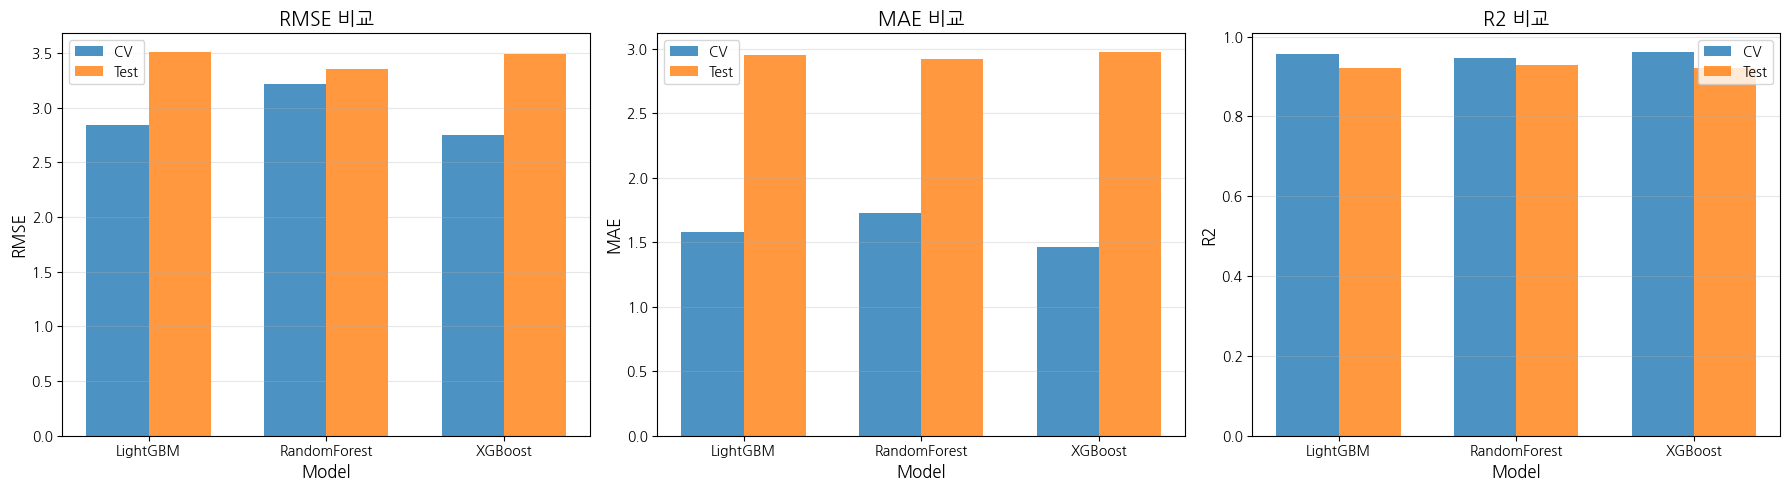

In [12]:
# ============================================================================
# 3종 모델 성능 비교
# ============================================================================
print("\n" + "="*80)
print("모델 성능 비교")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'XGBoost'],
    'CV_RMSE': [
        cv_df['val_rmse'].mean(),
        rf_cv_df['val_rmse'].mean(),
        xgb_cv_df['val_rmse'].mean()
    ],
    'CV_MAE': [
        cv_df['val_mae'].mean(),
        rf_cv_df['val_mae'].mean(),
        xgb_cv_df['val_mae'].mean()
    ],
    'CV_R2': [
        cv_df['val_r2'].mean(),
        rf_cv_df['val_r2'].mean(),
        xgb_cv_df['val_r2'].mean()
    ],
    'Test_RMSE': [test_rmse, rf_test_rmse, xgb_test_rmse],
    'Test_MAE': [test_mae, rf_test_mae, xgb_test_mae],
    'Test_R2': [test_r2, rf_test_r2, xgb_test_r2]
})

print("\n", comparison_df.to_string(index=False))
print("\n" + "="*80)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['RMSE', 'MAE', 'R2']
for idx, metric in enumerate(metrics):
    cv_col = f'CV_{metric}'
    test_col = f'Test_{metric}'

    x = np.arange(len(comparison_df))
    width = 0.35

    axes[idx].bar(x - width/2, comparison_df[cv_col], width, label='CV', alpha=0.8)
    axes[idx].bar(x + width/2, comparison_df[test_col], width, label='Test', alpha=0.8)

    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} 비교', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(comparison_df['Model'])
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
# ============================================================================
# 8. 변수 영향성 평가
# ============================================================================
print("\n[8단계] 변수 영향성 평가")
print("-"*80)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n【Feature Importance (전체)】")
for idx, row in feature_importance.iterrows():
    bar = '█' * int(row['Importance'] / feature_importance['Importance'].max() * 40)
    print(f"  {row['Feature']:20s} {bar} {row['Importance']:.1f}")

# SHAP 분석 (Test 데이터 대상)
print("\n【SHAP 값 계산 중...】")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap_importance = pd.DataFrame({
    'Feature': feature_cols,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("\n【SHAP Importance (전체)】")
for idx, row in shap_importance.iterrows():
    bar = '█' * int(row['SHAP_Importance'] / shap_importance['SHAP_Importance'].max() * 40)
    print(f"  {row['Feature']:20s} {bar} {row['SHAP_Importance']:.4f}")


[8단계] 변수 영향성 평가
--------------------------------------------------------------------------------

【Feature Importance (전체)】
  avg_temp (℃)         ████████████████████████████████████████ 2889.0
  Albedo               ████████████████████████████████ 2376.0
  NDBI                 ████████████████████████████ 2068.0
  NDVI                 ████████████████████████ 1754.0
  avg_humi (%)         █████████████████████ 1525.0
  avg_inte_illu (lux)  ████████████████ 1220.0
  month_cos            ██████████████ 1055.0
  year_norm            ██████████████ 1051.0
  에너지사용량_가스            █████████████ 955.0
  avg_ultra_rays (UV)  ████████████ 912.0
  총_가로수_개수             ████████████ 906.0
  녹지율                  ████████████ 892.0
  차량밀도                 ████████████ 875.0
  avg_noise (dB )      ████████████ 874.0
  에너지사용량_전기            ███████████ 842.0
  인구밀도                 ███████████ 832.0
  용적률_행정동별             ███████████ 826.0
  month_sin            █████████ 678.0
  누적_조성면적합계(m^2)       


[9단계] 결과 시각화
--------------------------------------------------------------------------------


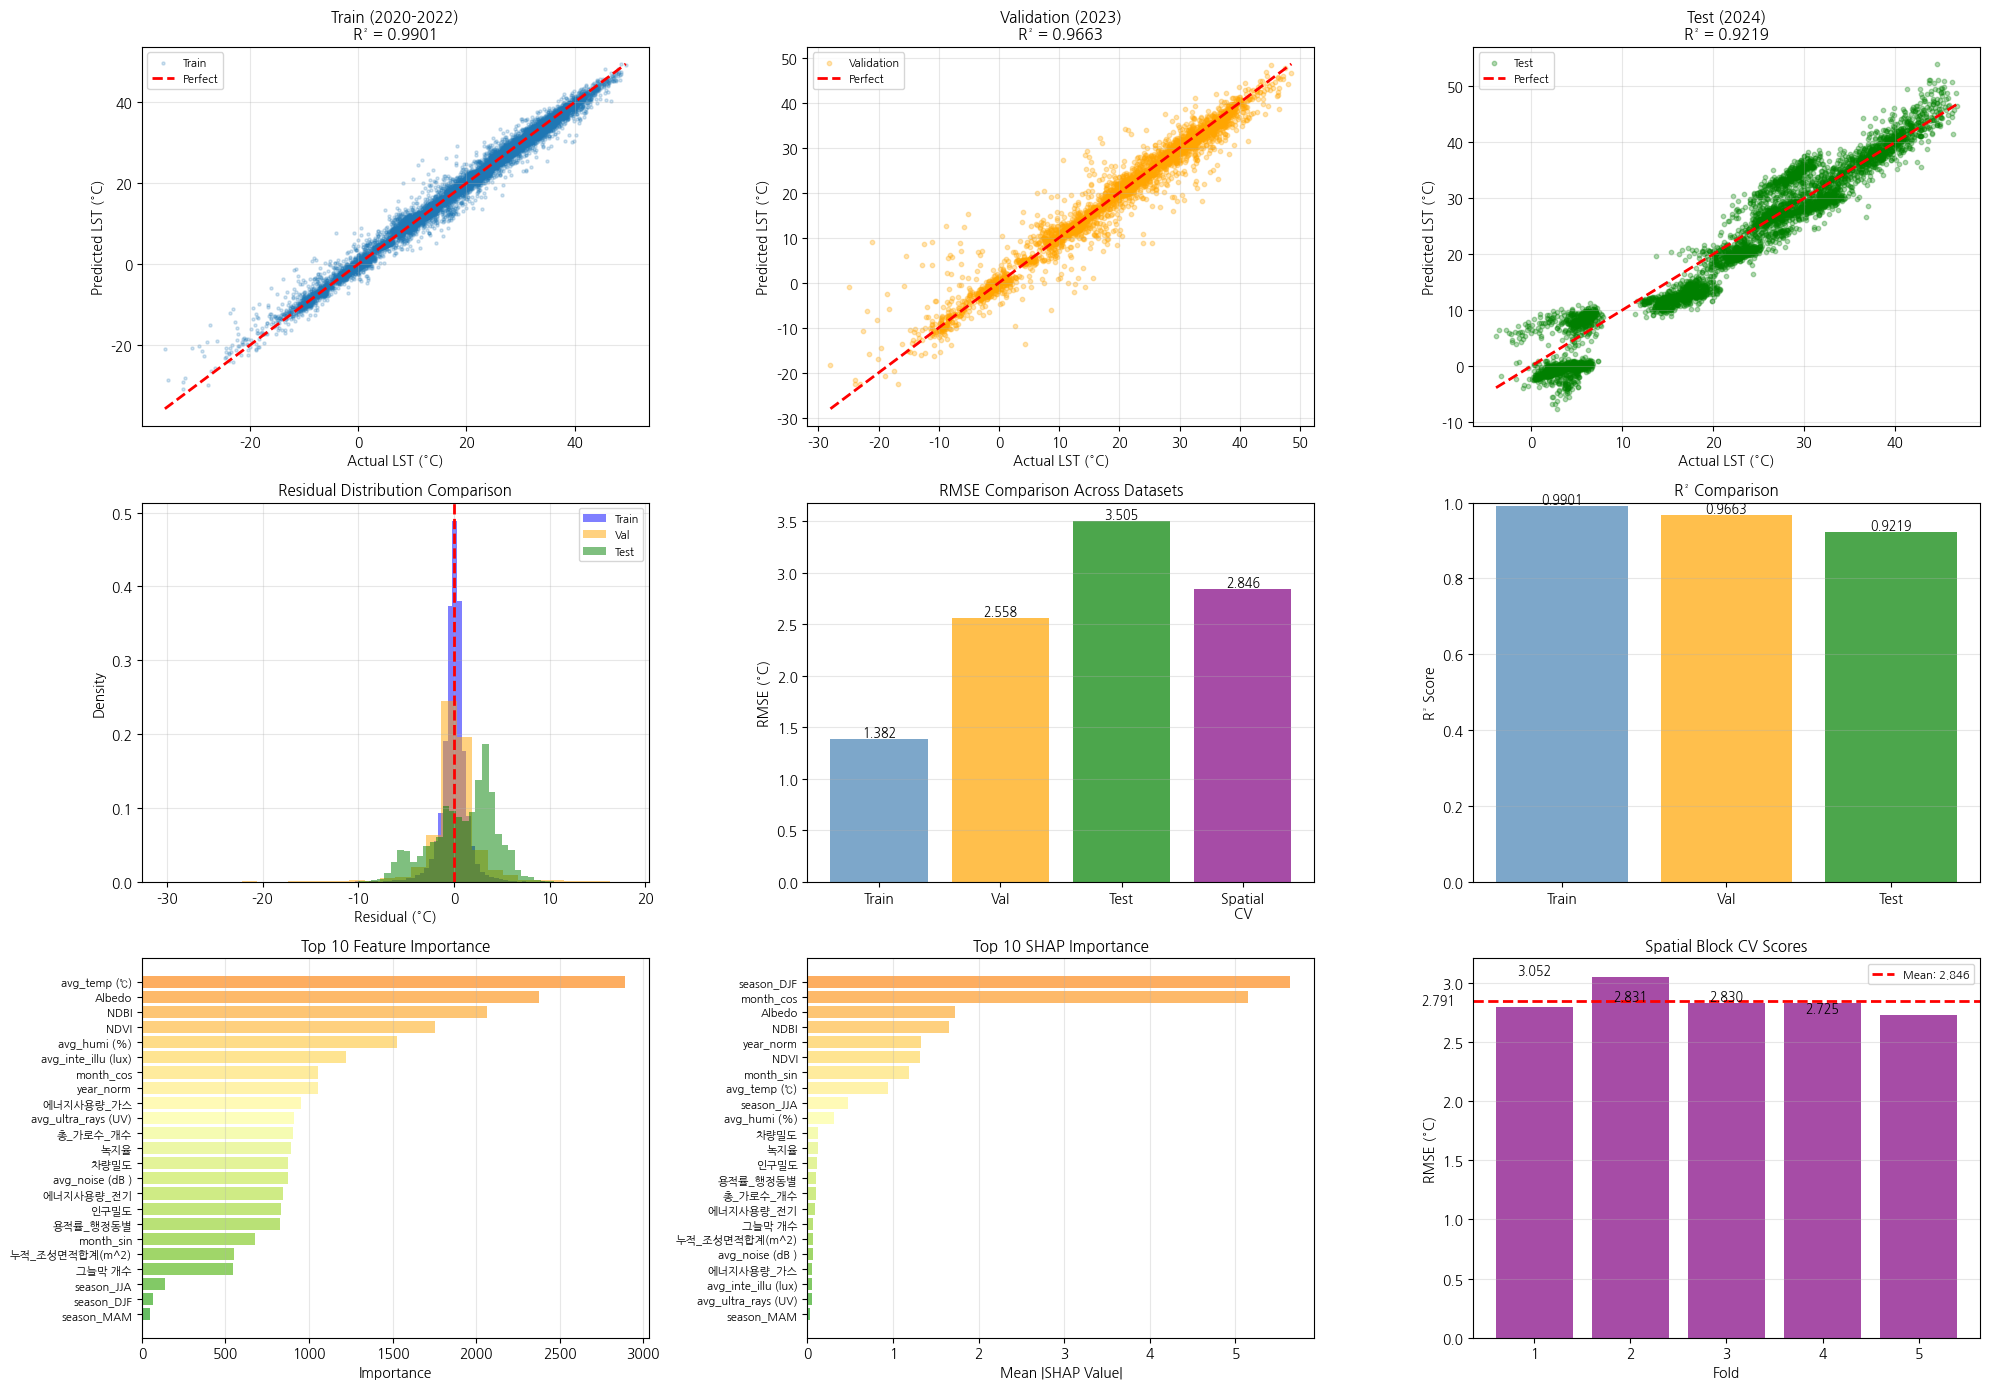

In [14]:
# ============================================================================
# 9. 시각화
# ============================================================================
print("\n[9단계] 결과 시각화")
print("-"*80)

fig = plt.figure(figsize=(20, 14))

# 1) Train: 예측 vs 실제
ax1 = plt.subplot(3, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.2, s=5, label='Train')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
         'r--', lw=2, label='Perfect')
plt.xlabel('Actual LST (°C)', fontsize=10)
plt.ylabel('Predicted LST (°C)', fontsize=10)
plt.title(f'Train (2020-2022)\nR² = {train_r2:.4f}', fontsize=11, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 2) Validation: 예측 vs 실제
ax2 = plt.subplot(3, 3, 2)
plt.scatter(y_val, y_val_pred, alpha=0.3, s=10, color='orange', label='Validation')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', lw=2, label='Perfect')
plt.xlabel('Actual LST (°C)', fontsize=10)
plt.ylabel('Predicted LST (°C)', fontsize=10)
plt.title(f'Validation (2023)\nR² = {val_r2:.4f}', fontsize=11, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 3) Test: 예측 vs 실제
ax3 = plt.subplot(3, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.3, s=10, color='green', label='Test')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect')
plt.xlabel('Actual LST (°C)', fontsize=10)
plt.ylabel('Predicted LST (°C)', fontsize=10)
plt.title(f'Test (2024)\nR² = {test_r2:.4f}', fontsize=11, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 4) 잔차 분포 비교
ax4 = plt.subplot(3, 3, 4)
residuals_train = y_train - y_train_pred
residuals_val = y_val - y_val_pred
residuals_test = y_test - y_test_pred

plt.hist(residuals_train, bins=50, alpha=0.5, label='Train', color='blue', density=True)
plt.hist(residuals_val, bins=30, alpha=0.5, label='Val', color='orange', density=True)
plt.hist(residuals_test, bins=30, alpha=0.5, label='Test', color='green', density=True)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residual (°C)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.title('Residual Distribution Comparison', fontsize=11, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 5) RMSE 비교
ax5 = plt.subplot(3, 3, 5)
datasets = ['Train', 'Val', 'Test', 'Spatial\nCV']
rmses = [train_rmse, val_rmse, test_rmse, np.mean(cv_scores)]
colors = ['steelblue', 'orange', 'green', 'purple']

bars = plt.bar(datasets, rmses, color=colors, alpha=0.7)
plt.ylabel('RMSE (°C)', fontsize=10)
plt.title('RMSE Comparison Across Datasets', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

for bar, rmse in zip(bars, rmses):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{rmse:.3f}', ha='center', va='bottom', fontsize=9)

# 6) R² 비교
ax6 = plt.subplot(3, 3, 6)
r2s = [train_r2, val_r2, test_r2]
bars = plt.bar(datasets[:3], r2s, color=colors[:3], alpha=0.7)
plt.ylabel('R² Score', fontsize=10)
plt.title('R² Comparison', fontsize=11, fontweight='bold')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')

for bar, r2 in zip(bars, r2s):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{r2:.4f}', ha='center', va='bottom', fontsize=9)

# 7) Feature Importance (상위 10개)
ax7 = plt.subplot(3, 3, 7)
top10_fi = feature_importance.head(23)
colors_fi = plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(top10_fi)))
plt.barh(range(len(top10_fi)), top10_fi['Importance'], color=colors_fi)
plt.yticks(range(len(top10_fi)), top10_fi['Feature'], fontsize=8)
plt.xlabel('Importance', fontsize=10)
plt.title('Top 10 Feature Importance', fontsize=11, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# 8) SHAP Importance (상위 10개)
ax8 = plt.subplot(3, 3, 8)
top10_shap = shap_importance.head(23)
colors_shap = plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(top10_shap)))
plt.barh(range(len(top10_shap)), top10_shap['SHAP_Importance'], color=colors_shap)
plt.yticks(range(len(top10_shap)), top10_shap['Feature'], fontsize=8)
plt.xlabel('Mean |SHAP Value|', fontsize=10)
plt.title('Top 10 SHAP Importance', fontsize=11, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# 9) 공간 CV 점수 분포
ax9 = plt.subplot(3, 3, 9)
plt.bar(range(1, 6), cv_scores, color='purple', alpha=0.7)
plt.axhline(np.mean(cv_scores), color='red', linestyle='--',
            label=f'Mean: {np.mean(cv_scores):.3f}', linewidth=2)
plt.xlabel('Fold', fontsize=10)
plt.ylabel('RMSE (°C)', fontsize=10)
plt.title('Spatial Block CV Scores', fontsize=11, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3, axis='y')

for i, score in enumerate(cv_scores, 1):
    plt.text(i-1, score, f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()


# 3. shap분석

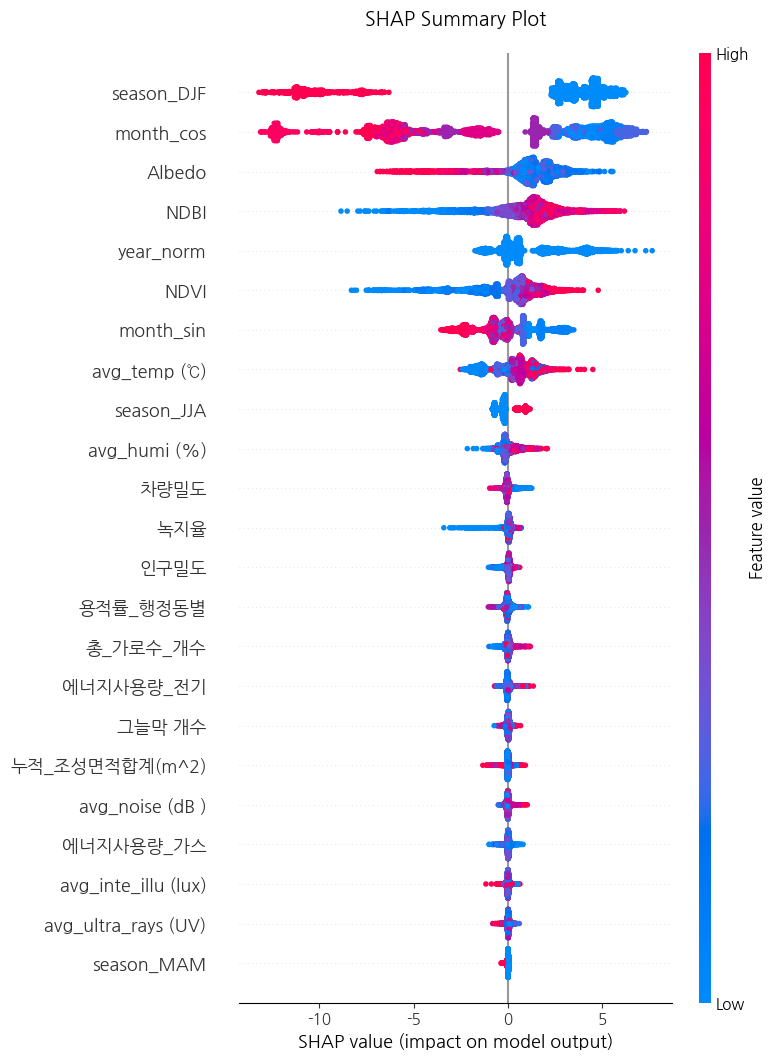

In [17]:

# ============================================================================
# SHAP Summary Plot
# ============================================================================
fig2 = plt.figure(figsize=(14, 8))

shap.summary_plot(shap_values, X_test, feature_names=feature_cols,
                  max_display=23, show=False)
plt.title('SHAP Summary Plot',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()


 저장: shap_dot.png


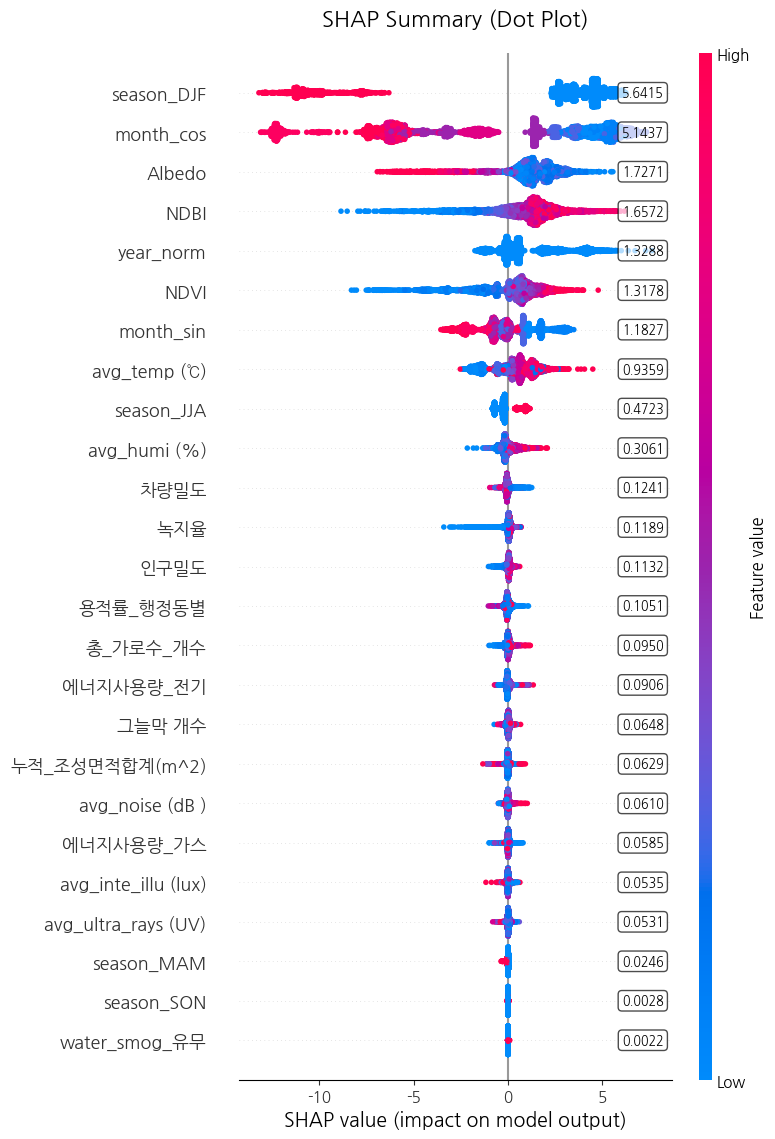


 SHAP 분석 완료!


In [22]:
# ============================================================================
# SHAP Dot Plot
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 20))
shap.summary_plot(shap_values, X_test,
                  feature_names=feature_cols,
                  max_display=len(feature_cols),
                  show=False,
                  plot_type='dot')

# 오른쪽에 SHAP 평균값 표시
for i, (feature, value) in enumerate(zip(shap_importance['Feature'], shap_importance['SHAP_Importance'])):
    # Dot plot의 경우 y축이 역순이므로 조정
    y_pos = len(shap_importance) - i - 1
    # 오른쪽 끝에서 약간 왼쪽에 표시
    x_max = ax.get_xlim()[1]
    ax.text(x_max * 0.95, y_pos, f'{value:.4f}',
            va='center', ha='right', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.title('SHAP Summary (Dot Plot)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=14)
plt.tight_layout()
plt.savefig('shap_dot.png', dpi=300, bbox_inches='tight')
print(" 저장: shap_dot.png")
plt.show()

print("\n" + "="*80)
print(" SHAP 분석 완료!")
print("="*80)

상위 6개 변수: season_DJF, month_cos, Albedo, NDBI, year_norm, NDVI

  1. season_DJF


<Figure size 1000x600 with 0 Axes>

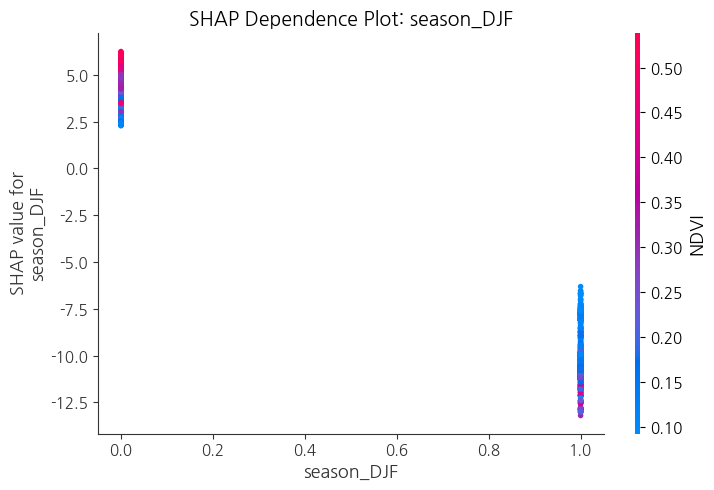


  2. month_cos


<Figure size 1000x600 with 0 Axes>

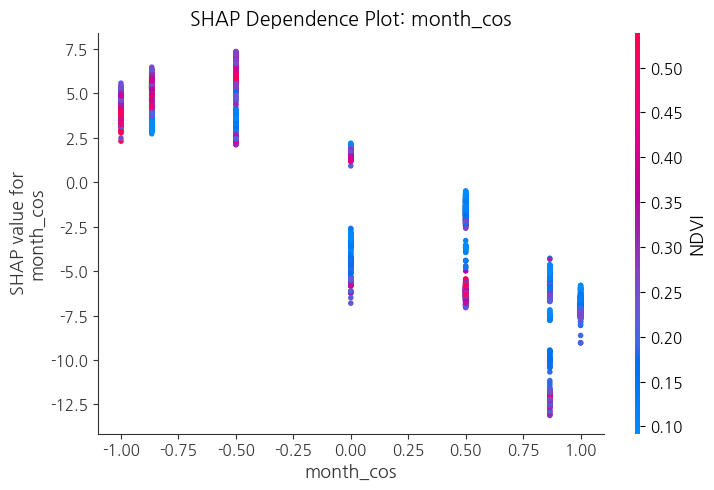


  3. Albedo


<Figure size 1000x600 with 0 Axes>

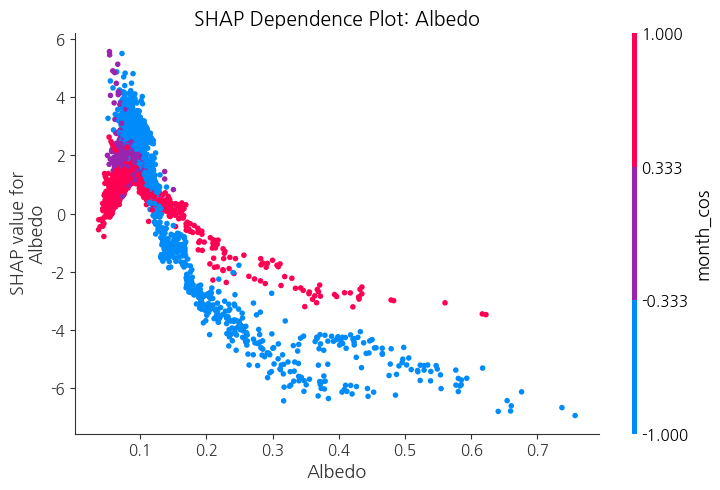


  4. NDBI


<Figure size 1000x600 with 0 Axes>

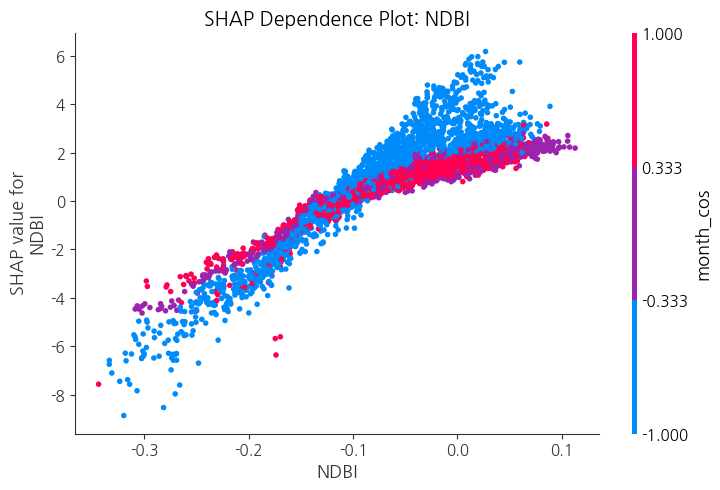


  5. year_norm


<Figure size 1000x600 with 0 Axes>

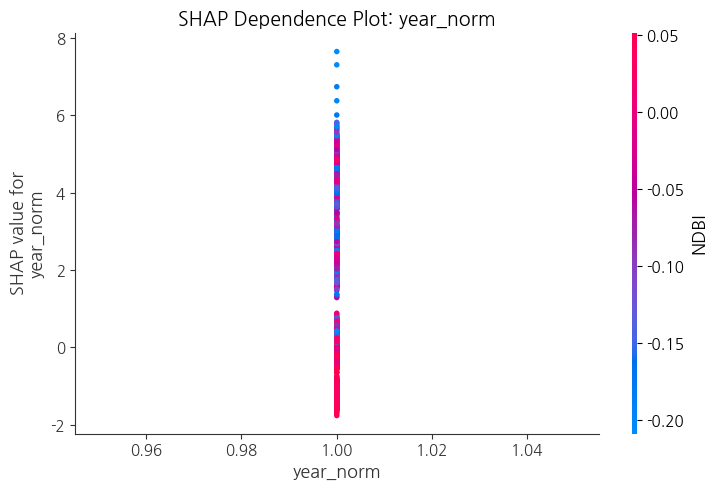


  6. NDVI


<Figure size 1000x600 with 0 Axes>

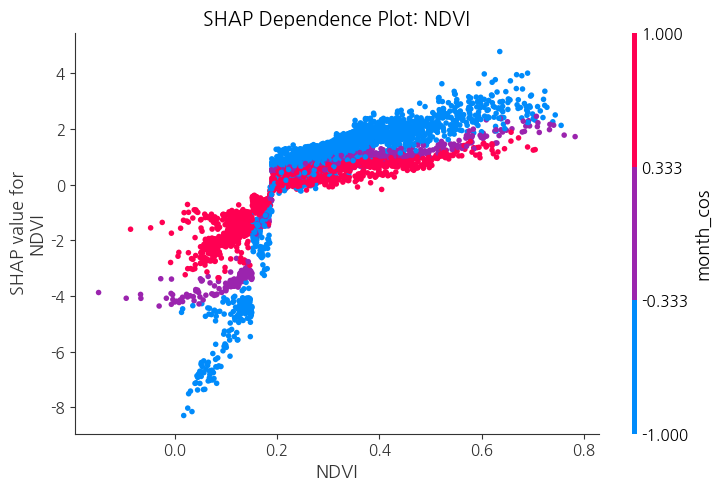

In [25]:
# ============================================================================
# SHAP Dependence Plots (주요 변수)
# ============================================================================

# SHAP 중요도 계산
shap_importance_values = np.abs(shap_values).mean(axis=0)
shap_ranking = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': shap_importance_values
}).sort_values('Importance', ascending=False)

# 상위 6개 변수
top_features = shap_ranking['Feature'].head(6).tolist()

print(f"상위 6개 변수: {', '.join(top_features)}")
print()

# 6개 변수를 각각 따로 그리기
for idx, feature in enumerate(top_features, 1):
    print(f"  {idx}. {feature}")
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        feature_names=feature_cols,
        show=False
    )
    plt.title(f'SHAP Dependence Plot: {feature}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print()


 SHAP Waterfall Plot (첫 번째 샘플)
 shap_waterfall.png


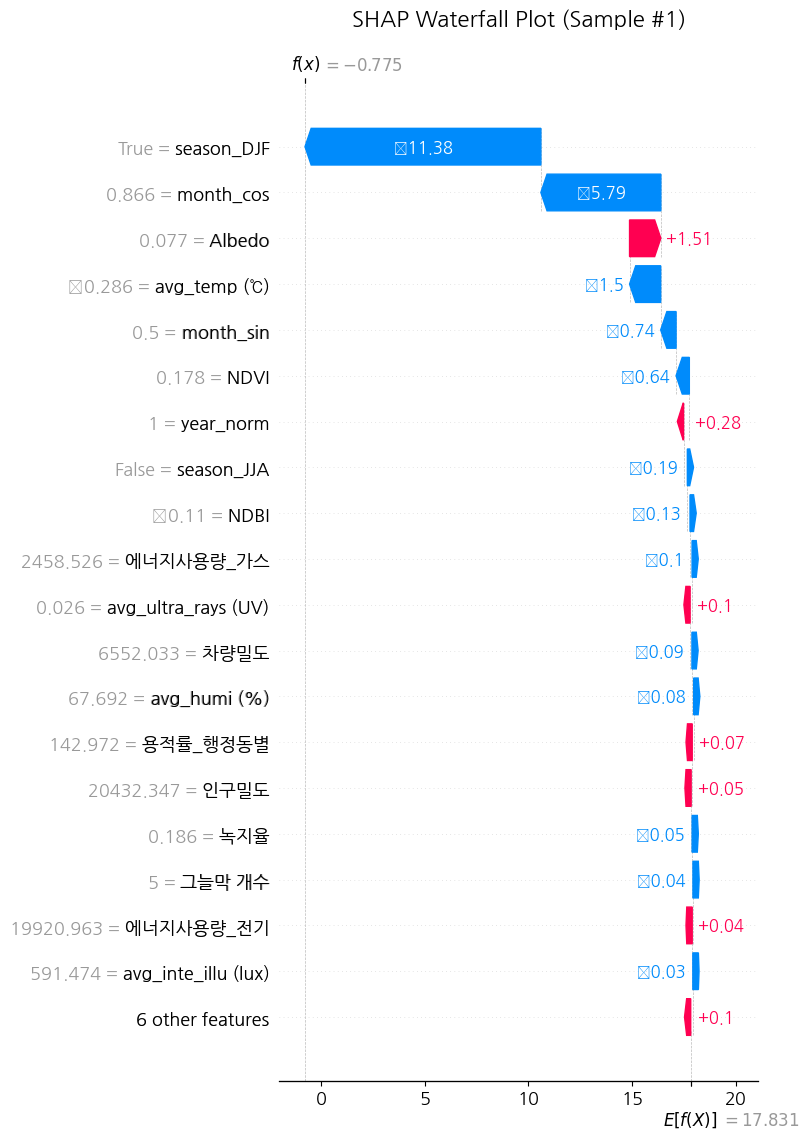

In [20]:
# ============================================================================
# SHAP Waterfall Plot (개별 샘플 예시)
# ============================================================================
print("\n SHAP Waterfall Plot (첫 번째 샘플)")

# SHAP Explanation 객체 생성
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test.values,
    feature_names=feature_cols
)

plt.figure(figsize=(12, 10))
shap.plots.waterfall(shap_explanation[0], max_display=20, show=False)
plt.title('SHAP Waterfall Plot (Sample #1)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=300, bbox_inches='tight')
print(" shap_waterfall.png")
plt.show()
